**WORK IN PROGRESS**

# Rationale

Sepsis is a life-threatening condition that arises when a patient's immune system responds to an infection in a disproportionate manner [(Mayo Clinic 2019)](https://www.mayoclinic.org/diseases-conditions/sepsis/symptoms-causes/syc-20351214). This causes the release of numerous hormones and related chemical responses in the body that can lead to tissue damage, which, if left untreated, can lead to organ failure and death [(Sepsis Alliance 2019)](https://www.sepsis.org/sepsis-basics/what-is-sepsis/). 

Early recognition of uncomplicated sepsis (i.e. no organ dysfunction) in patients presenting to Emergency Departments is associated with improved patient outcomes [(Seymour et al. 2017)](https://www.ncbi.nlm.nih.gov/pubmed/28528569). A recent study showed that an active alert system reduced inpatient mortality and morbidity on a large scale [(Honeyford et al. 2019)](https://academic.oup.com/jamia/advance-article/doi/10.1093/jamia/ocz186/5607431). This system made use of real time patient information to detect sepsis and alert healthcare givers to provide prompt treatment, leading to lower odds of death (OR: 0.76; 95%CI: 0.70-0.84). A similar system in Irish Emergency Departments could prove valuable, particularly given the ongoing 'trolley crisis' [(Halpin & Thomas 2019)](https://www.thejournal.ie/woman-70-left-for-105-hours-on-trolley-in-limerick-hospital-4832123-Oct2019/) and its association with increased patient mortality at 10 days [(Richardson 2006)](https://www.mja.com.au/system/files/issues/184_05_060306/ric10511_fm.pdf). 

# Aim

This notebook sets out the development of a dataset of simulated patients attending an Irish ED with uncomplicated sepsis. 

# Assumptions

1. In order for sepsis to be present, an infective source needs to be present. It will be assumed that if any of the patients within the dataset fulfill the criteria for sepsis, that they have a likely infective source


2. The dataset will only make use of clinical parameters that can be measured at presentation; that is, laboratory parameters will not be included in the dataset. The 'general variables' presented in Appendix 7 of the National Clinical Effectiveness Committee's Sepsis Managament National Clinical Guideline No. 6 [(National Clinical Effectiveness Committee 2014)](https://assets.gov.ie/11620/4678fb449336482fb291a140ef67e570.pdf) will be the only variables of interest included in the dataset. These are as follows
    1. Temperature <36 or >38.3 degrees celsius
    2. Heart rate >90 beats per minute
    3. Respiratoty rate >20 breaths per minute
    4. Altered mental state, recorded as 'Yes' or 'No'
    5. Blood glucose level of >7.7 mmol/L in non-diabetic 
    
    
3. Patients with co-morbidities (e.g. diabetes, compromised immune system, etc) are at increased risk of developing sepsis [(Sepsis Alliance 2019)](https://www.sepsis.org/sepsis-basics/what-is-sepsis/). For the sake of this dataset, it will be assumed that no patient has a co-morbidity or prior medical history that places them at increased risk of developing uncomplicated sepsis.


4. Only patients between 18 and 65 years of age will be included in the dataset. Children have different physiological parameters than adults, and thus different cut-offs for defining sepsis [(Mathias, Mira and Larson 2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4913352/pdf/nihms790779.pdf). Adults over the age of 65 are more likely to have multiple co-morbidities [(Barnett et al 2012)], and thus including this population in the dataset will not accurately reflect a 'real' population. 


5. Gender will not be part of the dataset. Although gender is associated with outcomes in patients with *developed* sepsis, there is insufficient evidence that gender is a risk factor for *developing* sepsis [(McNevin et al. 2016)](http://imj.ie/3171-2/).

# Developing the dataset parameters

In [42]:
# Import necessary packages to create and plot dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Increase plot production image sizes
plt.rcParams["figure.figsize"] = (10,5)

The first step in developing a dataset of ED patients with uncomplicated sepsis is developing a population with 'normal' vital sign parameters. Once this dataset is created, patients are randomly selected from within this dataset and 'given' a diagnosis of sepsis with appropriate changes to their physiological parameters. The final dataset then contains a simulated population of ED patients, of which an appropriate random proportion will have uncomplicated sepsis based on vital sign changes as mentioned above. 

## Creating the 'normal' ED population

### Size
According to the Central Statistics Office (CSO) [(Central Statistics Office 2011)](https://www.cso.ie/en/media/csoie/releasespublications/documents/labourmarket/2010/healthstatusq32010.pdf), 10% of the adult Irish population over 18 years of age attended an ED. Based on the 2016 census [(Central Statistics Office 2018)](https://statbank.cso.ie/px/pxeirestat/Statire/SelectVarVal/Define.asp?maintable=EY007&PLanguage=0), the population of Ireland >18 years of age was estimated at 3,424,795. This equates to roughly 9,383 A&E visits across the country every day. However, the 10% CSO statistic includes repeat presentations; a report compiled by the HSE in 2006 [(HSE 2006)](https://www.hse.ie/eng/services/publications/hospitals/hse-emergency-departments--patient-profiles,-experiences-and-perceptions.pdf) placed this figure closer to 3,300. For the interest of this database, we will work with a daily ED attendance number of 3,500. 

### Age distribution
Presentations to ED are not evenly distributed across age categories, with a bimodal presentation at 18-24 years of age, and 70+ [(Central Statistics Office 2011)](https://www.cso.ie/en/media/csoie/releasespublications/documents/labourmarket/2010/healthstatusq32010.pdf). A bimodal distribution of this type can be represented by two normal distributions [(Ho 2018)](https://medium.com/@michellemho/faking-data-87c063cf38a7) centred around a mean of 18 and 70 respectively, with a standard deviation (SD) of 15 for each. This SD allows for ~95% of the sample from each distribution to arise between two SD from the mean. Although this does not make biological sense for the mean of 18 (2 SD of 15 years below 18 years will be equal to minus 12 years), it does ensure that there is overlap between the two distributions in the middle (between ~40 and ~48 years of age) as shown in the following plot: 


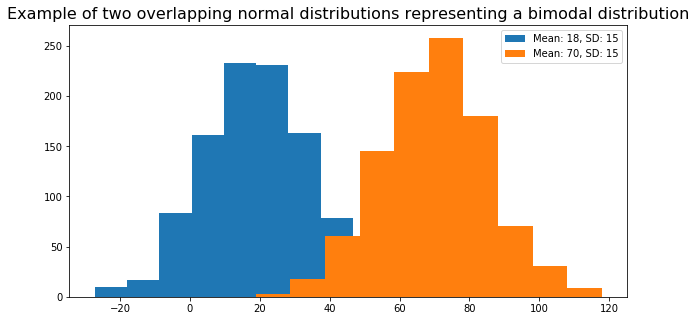

In [43]:
# Generate two normal distributions of 1,750 values, young and old, with mean of 18 and 70 respectively, 
# and standard deviation of 15
y = np.random.normal(18, 15, 1000)
o = np.random.normal(70, 15, 1000)

# Plot histograms of the two distributions on the same plot
plt.hist(y, label="Mean: 18, SD: 15")
plt.hist(o, label="Mean: 70, SD: 15")
# Add plot details
plt.title("Example of two overlapping normal distributions representing a bimodal distribution", fontsize=16)
plt.legend()

Thus, two normal distributions provide a bimodal distribution that represents the desired distribution as it occurs in reality. As there is roughly an equal proportion of attendees in the 18-24 age bracket (13%) and the 70+ age bracket (11%) [(Central Statistics Office 2011)](https://www.cso.ie/en/media/csoie/releasespublications/documents/labourmarket/2010/healthstatusq32010.pdf), an equal proportion from each distribution is sampled in this dataset as shown in the code !!here!! - add link.

### Vital signs

#### Temperature, heart rate and respiratory rate
The normal values for these vital signs are as follows [(National Institutes of Health 2019)](https://medlineplus.gov/ency/article/002341.htm):
- temperature: 36.5 to 37.3 degrees celsius
- heart rate: 60 to 100 beats per minute
- respiratory rate: 12 to 18 breaths per minute

Individual patient vital signs are calculated from within these ranges by selecting a random value from a normal distribution centred around the middle value (median) of the range, with a SD equal to the interquartile range (IQR) divided by 1.35 [(Researchgate 2014)](https://www.researchgate.net/post/Is_there_any_way_to_get_mean_and_SD_from_median_and_IQR_interquartile_range). For example, the mean and SD for the normal sampling distribution of temperature is calculated as follows:
 - mean = median = (37.3 + 36.5)/2 = 36.9
 - SD = IQR/1.35 = (37.3 - 36.5)/1.35 = 0.6

#### Blood glucose level
Blood glucose level is dependent on time since last meal [(Diabetes.co.uk 2019)](https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html), and normal will be considered any value within the following range:
- 4.0 (fasting) to 7.7mmol/L (post-prandial)

Calculation of values for this variable are performed in the same manner as above.  

#### Mental state
There are many ways of measuring mental status in the Emergency Department [(Xiao et al. 2012)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4129809/pdf/WJEM-3-270.pdf). For that reason, no single scale is defined for this variable. Instead, this is a binary variable: mental status is either altered ('yes') or normal ('no'). This variable is initially set at 'no'.

### Sepsis
The variable of sepsis is defined as either absent ('no') or present ('yes'). This variable is initially set as 'no' to reflect the initial non-septic population

## Creating sepsis patients randomly within the 'normal' ED population

In [3]:
# Create counter and population size
count = 0
pop = 3500

# Create list of ages (this will be converted to a dataframe for analysis in due course)
ages = []

# Generate a random list of 3,500 ages from a bimodal distribution
# Run through the random samples as they are generated, and only add ages > 18 and < 75 to the list
while count < pop:
    yng = int(np.random.normal(18, 15)) # Young normal distribution centred around a mean of 15, SD of 15
    # print(yng)
    old = int(np.random.normal(70, 15)) # Old normal distribution centred around a mean of 70, SD of 15
    # print(old)
    if yng < 18:
        continue
    if old > 75:
        continue
    else:
        ages.append(yng)
        ages.append(old)
        count += 2 # Increment count by 2 each time for yng and old age addition

(array([  2., 382., 586., 386., 313., 246., 249., 364., 456., 516.]),
 array([ 8. , 14.7, 21.4, 28.1, 34.8, 41.5, 48.2, 54.9, 61.6, 68.3, 75. ]),
 <a list of 10 Patch objects>)

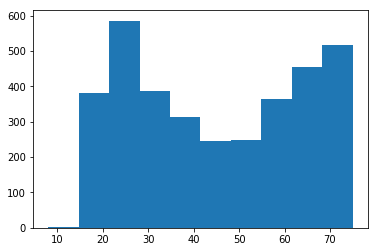

In [4]:
# Plot list to confirm bimodal distribution
plt.hist(ages)

For the purposes of this equation, the mean for each value (apart from mental state) will be the median of the ranges shown. The standard deviation (SD) will be 1/3 the value between the median and the lower/upper limit of the range. This will ensure that 99% of values chosen are within the ranges shown. As a normal distribution is asymptotic, additional conditionals will be employed to ensure all values fall between the ranges as shown.

[1]: https://medlineplus.gov/ency/article/002341.htm
[2]: https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html

In [45]:
sd = abs(round((36.5-37.3)/1.35, 2))
sd

0.59

In [5]:
'''Create values function to select values from normal range:
    Takes 3 arguments type integer or float:
                        a = lower range limit
                        b = upper range limit
                        size = population size
    Returns a list of values from a normal distribution between a and b of size 'size' '''


def values(a, b, size): # a and b are range limits; size is population size
    # calculate mean
    mn = abs(round((a+b)/2, 2))
    
    # calculate sd
    sd = abs(round((a-b)/1.35, 2))
    
    # set counter
    count = 0
    
    # create empty list
    ls = []
    
    # determine values
    while count < size:
        x = (np.random.normal(mn, sd))
        if x < a or x > b:
            continue
        else:
            ls.append(x)
            count += 1
        
    # return list
    return ls

In [6]:
# Create lists of normal vital signs
temp = values(36.5, 37.3, pop)
hr = values(60, 100, pop)
rr = values(12, 18, pop)
gluc = values(4.0, 7.7, pop)

Text(0, 0.5, 'Count')

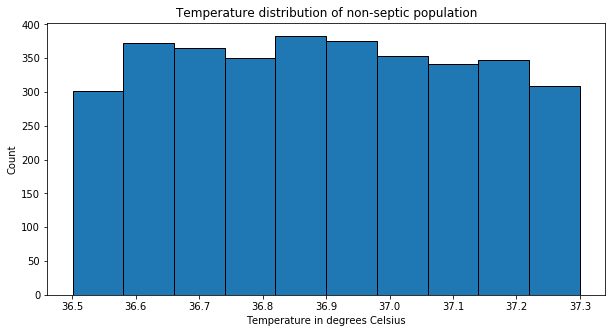

In [46]:
# Plot temp
plt.hist(temp, edgecolor='k')
plt.title('Temperature distribution of non-septic population')
plt.xlabel('Temperature in degrees Celsius')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

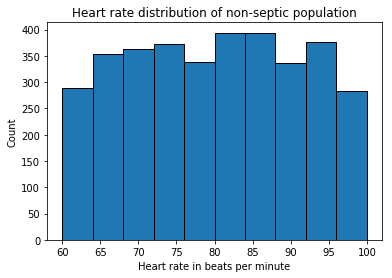

In [8]:
# Plot hr
plt.hist(hr, edgecolor='k')
plt.title('Heart rate distribution of non-septic population')
plt.xlabel('Heart rate in beats per minute')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

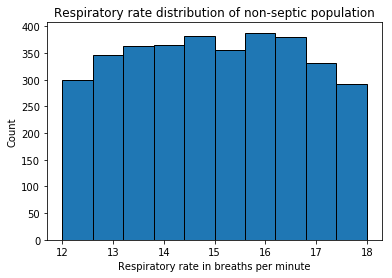

In [9]:
# Plot rr
plt.hist(rr, edgecolor='k')
plt.title('Respiratory rate distribution of non-septic population')
plt.xlabel('Respiratory rate in breaths per minute')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

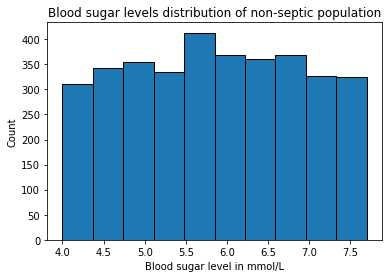

In [10]:
# Plot gluc
plt.hist(gluc, edgecolor='k')
plt.title('Blood sugar levels distribution of non-septic population')
plt.xlabel('Blood sugar level in mmol/L')
plt.ylabel('Count')

In [11]:
# Create dataframe of 'normal' patient values - https://stackoverflow.com/a/30522778
df = pd.DataFrame({'age': ages, 'temp': temp, 'pulse': hr, 'resp_rate': rr, 'sugar': gluc})

In [12]:
# Round values appropriately - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.round.html
df = df.round({'temp': 1, 'pulse': 0, 'resp_rate': 0, 'sugar': 1})

In [13]:
# Convert pulse and resp rate float columns to integers - https://stackoverflow.com/a/21291622
df.pulse = df.pulse.astype(int)
df.resp_rate = df.resp_rate.astype(int)

In [14]:
# Add in the mental status column with all values at 'No' - https://www.interviewqs.com/ddi_code_snippets/add_new_col_df_default_value
df['alt_ment'] = 'no'

# Add in sepsis column with all values at 'no'
df['sepsis'] = 'no'

In [15]:
# Confirm that values entered of correct type
print(df.dtypes)

age            int64
temp         float64
pulse          int64
resp_rate      int64
sugar        float64
alt_ment      object
sepsis        object
dtype: object


In [16]:
# Confirm dataframe stored correctly
df.head()

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
0,19,36.9,65,16,6.5,no,no
1,56,36.7,71,14,6.3,no,no
2,38,37.0,68,12,5.6,no,no
3,62,37.2,70,12,7.4,no,no
4,54,37.0,70,14,7.6,no,no


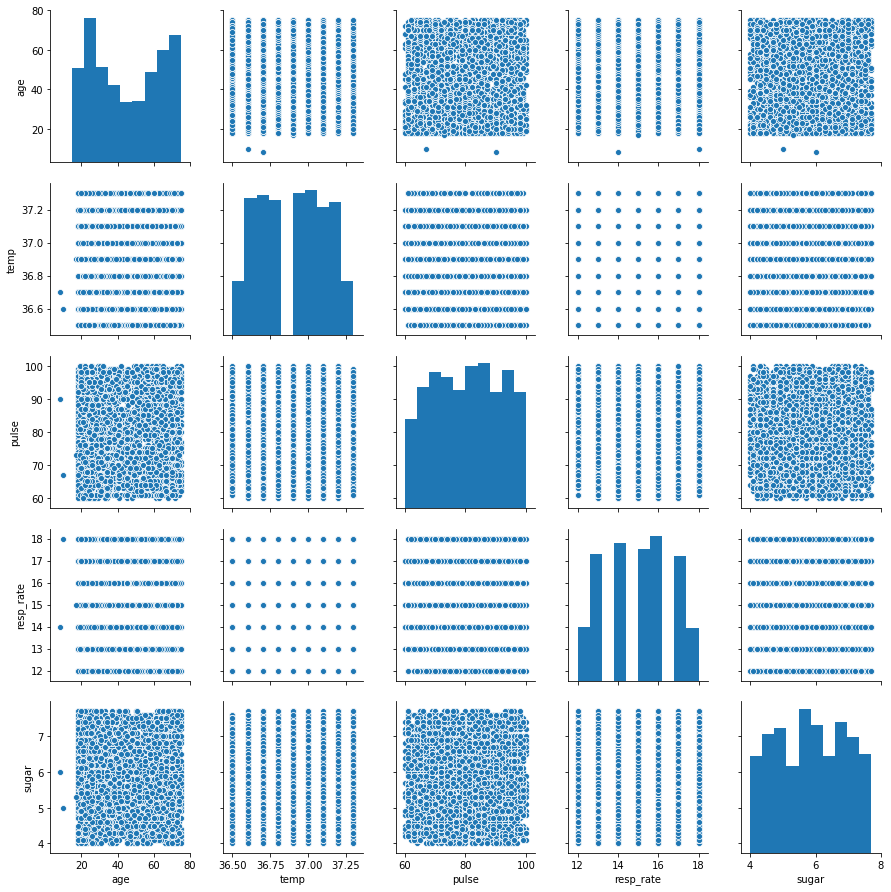

In [17]:
import seaborn as sns
sns.pairplot(df)

In [18]:
df.describe()

,age,temp,pulse,resp_rate,sugar
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,45.033143,36.897943,80.028286,15.001429,5.855686
std,18.703460,0.227179,11.119993,1.706953,1.036642
min,8.000000,36.500000,60.000000,12.000000,4.000000
25%,27.000000,36.700000,71.000000,14.000000,5.000000
50%,44.000000,36.900000,80.000000,15.000000,5.800000
75%,63.000000,37.100000,90.000000,16.000000,6.700000
max,75.000000,37.300000,100.000000,18.000000,7.700000


##### Create sepsis patients
According to a [study][1] conducted in one of the busiest EDs in Ireland, roughly 4.24% of ED presentations are suffering from sepsis. This proportion is not evenly distributed, with older patients more likely to have sepsis (median 45 without sepsis versus a median of 65 for those with sepsis). In order to accurately reflect this, we will randomly select 4% of the sample between the ages of 50 and 75 to have sepsis. We will then select 0.5% from the remaining sample to have sepsis to represent the possibility of sepsis at all ages.

Not making decision on gender as per article.

[1]: https://www.lenus.ie/bitstream/handle/10147/620877/art3.html?sequence=1

All samples drawn from uniform distribution. Why not normal? As mean unknown, don't know if these samples are skewed. And what is the SD? However, is possible to calculate this from median ans IQR if assumed normal distribution - mean = median, SD = IQR/1.35 (https://www.researchgate.net/post/Is_there_any_way_to_get_mean_and_SD_from_median_and_IQR_interquartile_range)

Median hearbeat from study - 104, IQR 89-113. Thus, draw from range 91 to 130 (IQR between median and IQR is 15. Assuming that additional 15 on top end is complete range of study, thus 130).

Temp - median of 36.7, IQR of 36 to 38. Thus, applying above logic again, upper end of range is 39.3, lower end of range is 36 - 0.7 = 35.3. Need to select randomly from lower (<36) or upper range (>38.3).

Median resp rate was 18, IQR 16-20. Thus, applying same principle as above, range is 14-22. Only rr > 20 is indicative. 

Sugar median was 7.6, IQR 6-9 mmol/L. thus, applying same above principle, range is 4.4 - 10.4. Thus, sepsis is range 7.8 to 10.4

In [19]:
# Create proportion of sample
older = int(pop*0.04)
rest = int(pop*0.005)

In [20]:
def sepsis(a, b): # a is the df row; b is the number of variables to change
    vitals = np.array(['temp', 'pulse', 'resp_rate', 'sugar', 'alt_ment']) # https://docs.scipy.org/doc/numpy-1.13.0/user/basics.creation.html
    for i in range(b):
    # Randomly select variables to change
        vc = np.random.choice(vitals)
        vitals = vitals[vitals!=vc] # https://thispointer.com/delete-elements-from-a-numpy-array-by-value-or-conditions-in-python/
        # print(vc)
        # print(vitals)
        if vc == 'pulse':
            a.at[:, 'pulse'] = np.random.randint(91, 131) # https://www.edureka.co/community/43220/how-to-change-update-cell-value-in-python-pandas-dataframe
            # print(a)
        if vc == 'temp':
            # decide on random upper or lower limit using binomial distribution
            dec = np.random.binomial(1, 0.5)
            if dec == 1:
                a.at[:, 'temp'] = np.random.choice(np.arange(38.3, 39.4))
            else:
                a.at[:, 'temp'] = np.random.choice(np.arange(35.3, 36.1))
            # print(a)
        if vc == 'resp_rate':
            a.at[:, 'resp_rate'] = np.random.randint(21, 23)
            # print(a)
        if vc == 'sugar':
            a.at[:, 'sugar'] = np.random.choice(np.arange(7.8, 10.5))
            # print(a)
        if vc == 'alt_ment':
            a.at[:, 'alt_ment'] = 'yes'
            # print(a)
    a.at[:, 'sepsis'] = 'yes'  
    #print(a)

Selecting number of vitals to change - not evenly distributed. Proportion decreases with following p:
2 - 55% of patients
3 - 36%
4 - 7%
5 - 2%
Need to reflect this in numbers

In [21]:
# Create loop to change proportion of sample

# Reset counter
count = 0

# Run through older proportion of sample 
while count < older:
    # Choose observation randomly, but over 50
    x = df.loc[df.age >= 50].sample() # https://www.pybloggers.com/2018/11/how-to-use-pandas-sample-to-select-rows-and-columns/
    # print(x)
    if (x['sepsis'] == 'yes').bool(): # https://stackoverflow.com/a/36922103
        continue
    # Randomly determine number of vital signs to change - 2, 3, 4, or 5 - with reducing probability - https://stackoverflow.com/a/4266645
    num = np.random.choice(np.arange(2, 6), p=[0.55, 0.36, 0.07, 0.02])
    # print(num)
    # Adjust the corresponding number of vital signs using the sepsis function
    sepsis(x, num)
    df = df.append(x) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
    # print(x)
    count += 1
    # print(count) 

In [22]:
# Run through rest of sample

# Reset count
count = 0 

# Run through rest of sample
while count < rest: 
    # Choose observation randomly
    x = df.sample() # https://www.pybloggers.com/2018/11/how-to-use-pandas-sample-to-select-rows-and-columns/
    # print(x)
    if (x['sepsis'] == 'yes').bool(): # https://stackoverflow.com/a/36922103
        continue
    # Randomly determine number of vital signs to change - 2, 3, 4, or 5 - with reducing probability - https://stackoverflow.com/a/4266645
    num = np.random.choice(np.arange(2, 6), p=[0.55, 0.36, 0.07, 0.02])
    # print(num)
    # Adjust the corresponding number of vital signs using the sepsis function
    sepsis(x, num)
    df = df.append(x) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
    # print(x)
    count += 1
    # print(count) 

In [23]:
df = df.loc[~df.index.duplicated(keep='last')] # https://stackoverflow.com/a/34297689

In [24]:
df

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
0,19,36.9,65,16,6.5,no,no
1,56,36.7,71,14,6.3,no,no
2,38,37.0,68,12,5.6,no,no
4,54,37.0,70,14,7.6,no,no
5,45,36.7,60,14,4.8,no,no
6,19,36.8,65,18,5.2,no,no
7,68,36.7,89,14,7.3,no,no
8,21,36.6,99,13,6.0,no,no
9,45,36.8,78,18,4.7,no,no
10,34,37.3,74,16,4.9,no,no


In [25]:
df.sort_index() # http://www.datasciencemadesimple.com/sort-the-dataframe-in-python-pandas-by-index/

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
0,19,36.9,65,16,6.5,no,no
1,56,36.7,71,14,6.3,no,no
2,38,37.0,68,12,5.6,no,no
3,62,35.3,113,12,7.4,no,yes
4,54,37.0,70,14,7.6,no,no
5,45,36.7,60,14,4.8,no,no
6,19,36.8,65,18,5.2,no,no
7,68,36.7,89,14,7.3,no,no
8,21,36.6,99,13,6.0,no,no
9,45,36.8,78,18,4.7,no,no


In [26]:
z = df['sepsis'].value_counts()

In [27]:
z.yes/z.no*100

4.508808599581965

In [28]:
x = df[df['sepsis']=='yes']
x['age'].median()

63.0

In [29]:
x['temp'].mean()

36.97615894039741

In [30]:
x['pulse']

1435    110
3259    120
2107    113
555      85
1287     74
2919    103
2825    101
3306     82
1629     69
181     113
981      71
3471    124
1899     86
913      93
477      67
2538    103
2569    117
1065     69
2723    112
1783     85
1873     61
3055    130
2287    106
2419     88
2181     80
1753    118
2939     99
97       91
1297     63
2833    119
       ... 
2855    117
1595    103
2607     92
1451    126
3401    121
1557     66
1239     79
2171     88
1767     66
2389     98
2239     86
2545    125
2345    105
1235     91
2779     99
1124     87
1854     85
1112     66
1069     65
2138     69
2869     61
2588     93
767     128
3156     69
2451     69
3120    128
2887    127
2554    126
2715     97
85      114
Name: pulse, Length: 151, dtype: int64

In [31]:
import seaborn as sns

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


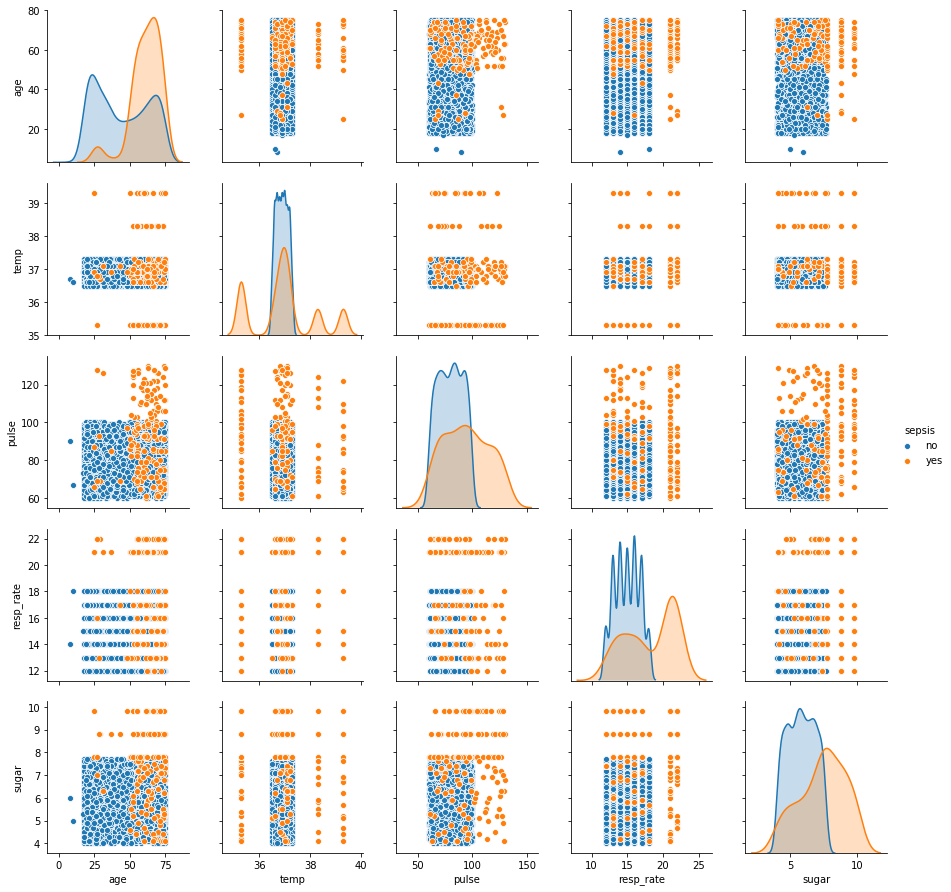

In [32]:
sns.pairplot(df, hue='sepsis')

In [33]:
x['temp']

1435    37.2
3259    37.2
2107    35.3
555     36.9
1287    38.3
2919    36.8
2825    37.0
3306    36.8
1629    39.3
181     38.3
981     38.3
3471    36.7
1899    39.3
913     36.7
477     35.3
2538    37.1
2569    36.9
1065    37.0
2723    37.3
1783    35.3
1873    38.3
3055    37.1
2287    35.3
2419    38.3
2181    35.3
1753    38.3
2939    35.3
97      35.3
1297    39.3
2833    35.3
        ... 
2855    35.3
1595    36.6
2607    37.1
1451    37.2
3401    37.1
1557    37.1
1239    36.6
2171    36.9
1767    35.3
2389    36.6
2239    35.3
2545    37.0
2345    37.0
1235    37.2
2779    37.3
1124    36.9
1854    36.9
1112    39.3
1069    36.6
2138    36.7
2869    38.3
2588    36.8
767     36.9
3156    36.8
2451    37.1
3120    35.3
2887    36.6
2554    37.1
2715    36.9
85      37.0
Name: temp, Length: 151, dtype: float64

In [34]:
import sklearn.neighbors as nei
import sklearn.model_selection as mod

In [35]:
inputs=df[['age', 'temp', 'pulse', 'resp_rate', 'sugar']]
outputs=df['sepsis']

In [36]:
inputs_train, inputs_test, outputs_train, outputs_test = mod.train_test_split(inputs, outputs, test_size=0.33)

In [37]:
knn = nei.KNeighborsClassifier(n_neighbors=5)

In [38]:
knn.fit(inputs_train, outputs_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [39]:
knn.predict(inputs_test)

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [40]:
knn.predict(inputs_test) == outputs_test

2188    True
2694    True
1074    True
1109    True
446     True
571     True
1005    True
8       True
430     True
3241    True
1518    True
380     True
3175    True
1500    True
2019    True
607     True
234     True
2398    True
174     True
1503    True
3331    True
3375    True
62      True
2770    True
3199    True
1680    True
2231    True
1636    True
926     True
3096    True
        ... 
628     True
415     True
1382    True
103     True
2087    True
121     True
1269    True
2646    True
3083    True
1900    True
232     True
484     True
17      True
2125    True
1591    True
2049    True
1358    True
1564    True
1972    True
3121    True
160     True
3256    True
1725    True
2635    True
3035    True
219     True
1003    True
2768    True
3494    True
1966    True
Name: sepsis, Length: 1155, dtype: bool

In [41]:
(knn.predict(inputs_test) == outputs_test).sum()

1128